In [18]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Prio_n_step_Agent.Prio_DQN_Agent import Prio_DQN_Agent
from Prio_n_step_Agent.utils.random_agent import RandomAgent
from Prio_n_step_Agent.utils.actions import MORE_ACTIONS
import Prio_n_step_Agent.utils.stats_functions as sf
import hockey.hockey_env as h_env

from importlib import reload

In [19]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [20]:
reload(h_env)
env_name = "../weights/pure_prio_training_2_2_25"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5)
agent.Q.load(env_name, name= "episode_2500" )

stats, losses = sf.load_stats(env_name)

Network loaded from ../weights/pure_prio_training_2_2_25/weights/episode_2500.pth


Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/returns_plot.png


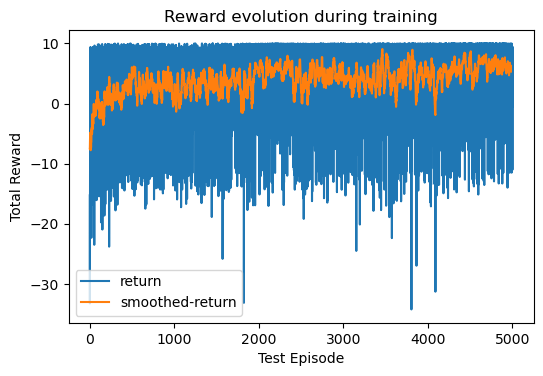

In [21]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/losses_plot.png


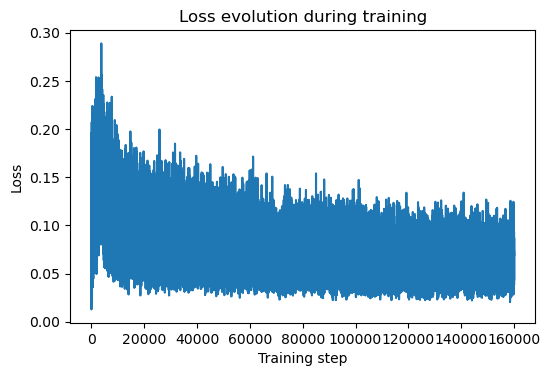

In [22]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/beta_evolution.png


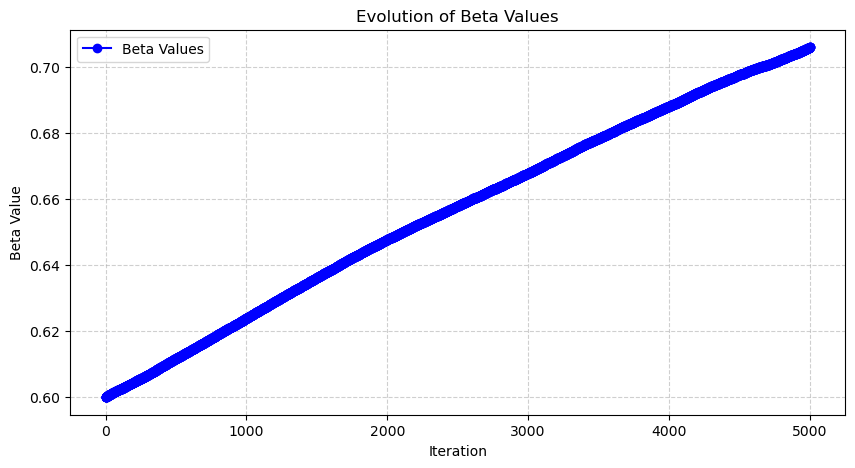

In [23]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/epsilon_evolution.png


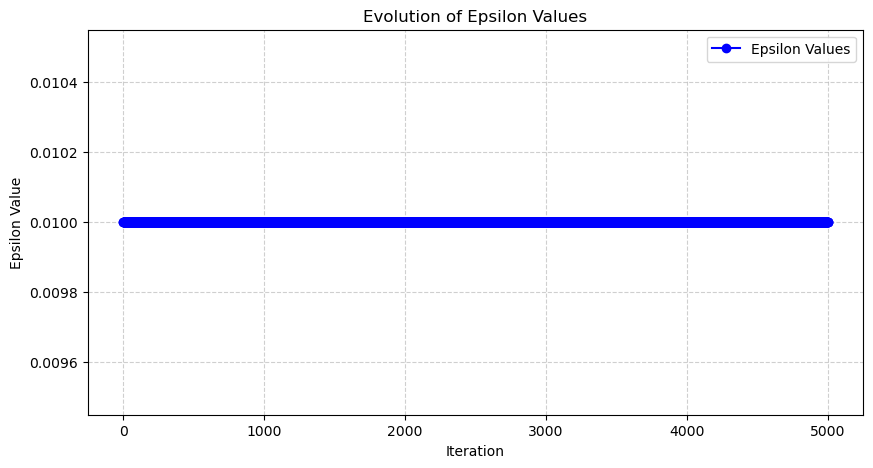

In [24]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/match_evolution.png


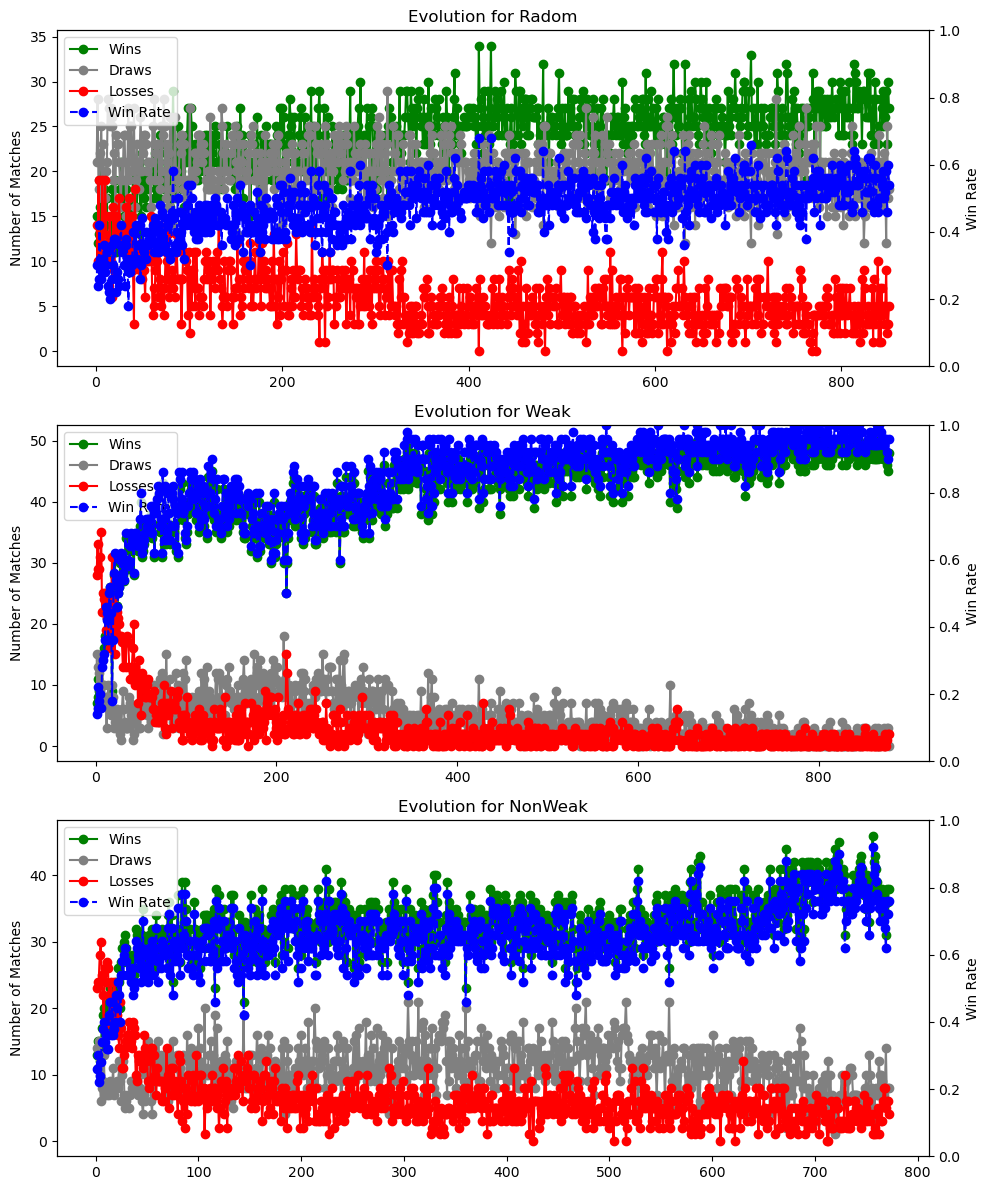

In [25]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history, ["Radom", "Weak", "NonWeak"], 50)

Test Episode 1, Total Reward: 0.0
Test Episode 2, Total Reward: -13.653527642582935
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: -15.308903059848614
Test Episode 5, Total Reward: -4.234209957858474
Test Episode 6, Total Reward: 9.612000657206044
Test Episode 7, Total Reward: 0.0
Test Episode 8, Total Reward: 9.439518409541696
Test Episode 9, Total Reward: 9.373600977046049
Test Episode 10, Total Reward: 7.486870587228077
Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/test_results_random.png


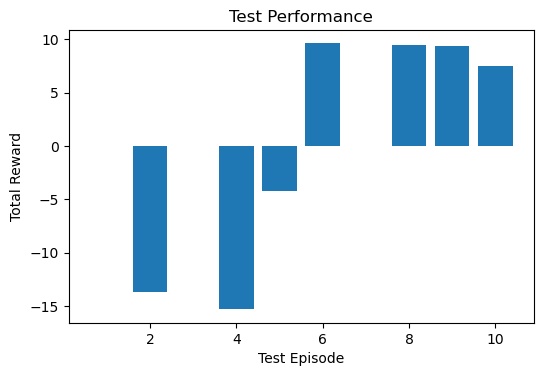

In [26]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = RandomAgent(seed)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/random", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/random/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_random")

Test Episode 1, Total Reward: 9.975425354141729
Test Episode 2, Total Reward: 5.076152783878947
Test Episode 3, Total Reward: -10.750778272466704
Test Episode 4, Total Reward: 9.600787841884145
Test Episode 5, Total Reward: -11.58445338198184
Test Episode 6, Total Reward: 9.605796064446848
Test Episode 7, Total Reward: 9.586028883530389
Test Episode 8, Total Reward: 9.509076259023939
Test Episode 9, Total Reward: 9.672186603791124
Test Episode 10, Total Reward: 9.608096450205595
Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/test_results_weak.png


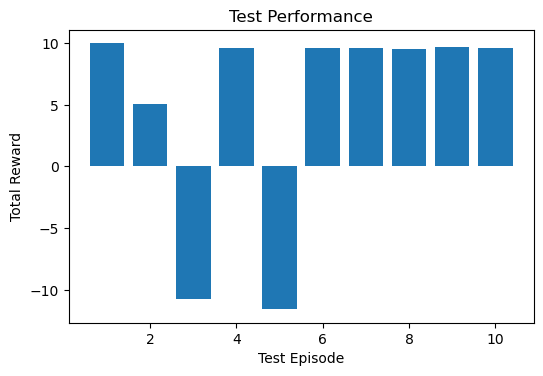

In [27]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent()

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/weak", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/weak/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_weak")

Test Episode 1, Total Reward: -6.688005333251153
Test Episode 2, Total Reward: 7.774189850188728
Test Episode 3, Total Reward: 8.136845403162184
Test Episode 4, Total Reward: 8.263688610045154
Test Episode 5, Total Reward: 8.616930337818028
Test Episode 6, Total Reward: 9.605796064446848
Test Episode 7, Total Reward: 3.2523391733114932
Test Episode 8, Total Reward: -3.618194612322193
Test Episode 9, Total Reward: -1.9346176371133268
Test Episode 10, Total Reward: 9.611044265956487
Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/test_results_nonweak.png


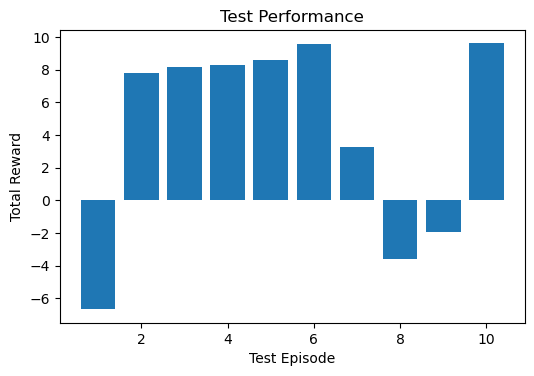

In [28]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent(weak=False)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/nonweak", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/nonweak/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_nonweak")

In [29]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")

TypeError: list indices must be integers or slices, not NoneType